# Estimating the determinants of food prices using regression models

This project aims to gain a deeper understanding of the factors that impact food prices within grocery stores using regression analysis. By identifying and quantifying the determinants, businesses can make more informed decisions in regards to their pricing strategies, marketing efforts and customer segmentation.

#### Identification and conceptual framework

We will try to develop a conceptual framework to guide the analysis and determine the appropriate structure of the regression model. However, we provide here practical approach to developing a regression model and more in-depth theoretical background is outside the scope of this work.

1. Defining the research question - Our research question is to determine the factors that impact the prices of food products.
2. Specifying the causal relationship -  We aim to establish a causal relationship between the prices of food products and various factors such as manufacturer, store type, and location.
3. Determining relevant data - To answer our research question, we will use data from the food retail industry, including information about the product, manufacturer, retail chain, store, store type, district, city, statistical area, and population. We will also consider the final price of the food product as the dependent variable.
4. Identifying potential confounding - Variables that could influence both food prices and the independent variables might include consumer demand, cost of inputs and transportation costs. To to control these potential source of bias, we use control variables such as socio-economic data and geographic information. This will help us to minimize the impact of any omitted variables and ensure that our results accurately reflect the relationship between food prices and the independent variables.
    - Socio-economic data will be used to control for consumer demand by serving as a proxy for economic status of a population with socio-economic index. For example, a high socio-economic index value could indicate that the population has a higher purchasing power and greater ability to afford certain goods and services, including food.
    - geographic information will be used to control for consumer demand cost of inputs and transportation costs by reflecting the remoteness of an area from the sources and markets with peripherality index.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS, WLS, GLS
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Set the desired inputs
categories = ["rice","pasta","legumes and cereals","biscuits", "waffles", "chocolates", "black coffee", "toilet paper", "yogurt","cheese","canned food","wine","beer","water","non alcoholic carbonated beverages","non alcoholic non carbonated beverages","toothpaste","bread", "flour and semolina","gums and candies","honey and date honey", "jam and confiture", "ketchup, mayonnaise and mustard", "pastrami, sausage and kabanos", "pickled or smoked fish","deodorant","shower gel","shampoo"]
categories = ["rice","pasta"]

date = '2019-07-15'

In [3]:
# Import the store data
Store_data = pd.read_csv('C:/Users/data/Store_data_git.csv')
Store_data = Store_data[['StoreID','CityName','DistrictID', 'DistrictName', 'SubDistrictID', 'SubDistrictName','StoreType','LocationType','StatisticalArea','SocioEconomicCity','PeripheralityIndex']]


# Import the price data in one date
date_df = []
for category in categories:
    date_category_data = readRDS('G:/retail data/rds data/data by date/'+category+'/'+str(date)+'.rds')
    date_category_data = pandas2ri.rpy2py_dataframe(date_category_data)
    
    date_category_data['category'] = category
    
    date_df.append(date_category_data)

date_df = pd.concat(date_df)
#merge with the store data
date_df = date_df.merge(Store_data, on=['StoreID'], how='left')
#date_df = date_df[:10000]
date_df[:5]

,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,StoreID,StoreName,...,CityName,DistrictID,DistrictName,SubDistrictID,SubDistrictName,StoreType,LocationType,StatisticalArea,SocioEconomicCity,PeripheralityIndex
0,7.290014e+12,אורז בסמטי אהרוני דין שיווק וקליה 1 קילו,דין שיווק וקליה,אורז,10.0,דור אלון,10.0,AM:PM,1001.0,אבן גבירול (פינת ז'בוטינסקי),...,TEL AVIV - YAFO,5.0,TEL AVIV,51.0,TEL AVIV,Convenience,1,50000421,8,10
1,8.052780e+11,אורז בסמטי הודי טאג' מאהל 1 קילו,טאג' מאהל,אורז,10.0,דור אלון,10.0,AM:PM,1001.0,אבן גבירול (פינת ז'בוטינסקי),...,TEL AVIV - YAFO,5.0,TEL AVIV,51.0,TEL AVIV,Convenience,1,50000421,8,10
2,5.011158e+12,אורז בסמטי טילדה 1 קילו,טילדה,אורז,10.0,דור אלון,10.0,AM:PM,1001.0,אבן גבירול (פינת ז'בוטינסקי),...,TEL AVIV - YAFO,5.0,TEL AVIV,51.0,TEL AVIV,Convenience,1,50000421,8,10
3,8.901537e+12,אורז בסמטי מובחר וילי פוד 1 קילו,וילי פוד,אורז,10.0,דור אלון,10.0,AM:PM,1001.0,אבן גבירול (פינת ז'בוטינסקי),...,TEL AVIV - YAFO,5.0,TEL AVIV,51.0,TEL AVIV,Convenience,1,50000421,8,10
4,7.290101e+12,אורז בסמטי מלא סוגת 1 קילו,סוגת,אורז,10.0,דור אלון,10.0,AM:PM,1001.0,אבן גבירול (פינת ז'בוטינסקי),...,TEL AVIV - YAFO,5.0,TEL AVIV,51.0,TEL AVIV,Convenience,1,50000421,8,10


### Data pre-processing

Since we know that our dataset documents price changes during the day, we will aggragate the prices to the date level.

In [4]:
# group the data by product and store and calculate the mean of each date
data_agg = date_df.groupby(['ProductDescription','StoreID'], as_index = False).agg({'FinalPrice':'mean', 'Barcode':'first', 'ProductDescription':'first', 'Manufacturer':'first', 'Category':'first', 'ChainID':'first', 'ChainName':'first', 'SubChainID':'first', 'SubChainName':'first', 'StoreName':'first', 'Price':'mean', 'DistrictName':'first', 'SubDistrictName':'first','CityName':'first', 'StoreType':'first','LocationType':'first','StatisticalArea':'first','SocioEconomicCity':'first','PeripheralityIndex':'first'})
data_agg.dropna(inplace=True)
data_agg['Manufacturer_fact'] = pd.factorize(data_agg['Manufacturer'])[0].astype('str')
data_agg[:5]

,StoreID,FinalPrice,Barcode,ProductDescription,Manufacturer,Category,ChainID,ChainName,SubChainID,SubChainName,...,Price,DistrictName,SubDistrictName,CityName,StoreType,LocationType,StatisticalArea,SocioEconomicCity,PeripheralityIndex,Manufacturer_fact
0,1646.0,17.0,7.290011e+12,אורז אדום אורגני תבואות 500 גרם,תבואות,אורגני - אורז דגנים וקטניות,22.0,סטופ מרקט,37.0,סטופ מרקט,...,17.0,CENTRAL,HASHARON,BET HERUT,HD,7,8770001,8,6,0
1,1650.0,17.0,7.290011e+12,אורז אדום אורגני תבואות 500 גרם,תבואות,אורגני - אורז דגנים וקטניות,22.0,סטופ מרקט,37.0,סטופ מרקט,...,17.0,TEL AVIV,TEL AVIV,HERZLIYYA,HD,7,64000061,8,8,0
2,1651.0,17.0,7.290011e+12,אורז אדום אורגני תבואות 500 גרם,תבואות,אורגני - אורז דגנים וקטניות,22.0,סטופ מרקט,37.0,סטופ מרקט,...,17.0,HAIFA,HAIFA,YAGUR,HD,7,960001,6,5,0
3,1652.0,17.0,7.290011e+12,אורז אדום אורגני תבואות 500 גרם,תבואות,אורגני - אורז דגנים וקטניות,22.0,סטופ מרקט,37.0,סטופ מרקט,...,17.0,HAIFA,HAIFA,HAIFA,HD,2,40000211,7,6,0
4,1654.0,17.0,7.290011e+12,אורז אדום אורגני תבואות 500 גרם,תבואות,אורגני - אורז דגנים וקטניות,22.0,סטופ מרקט,37.0,סטופ מרקט,...,17.0,HAIFA,HAIFA,HAIFA,HD,4,40000433,7,6,0


### Exploratory data analysis (EDA)

##### Histogram

We will plot the price distribution to identify outliers and skewness in the data, and to check if it follows a normal distribution, which is one of the assumptions of linear regression models.

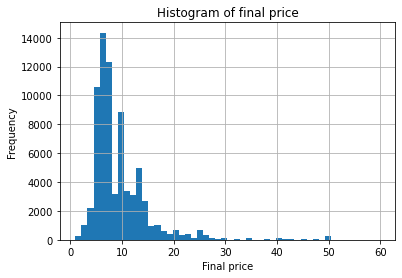

In [5]:
data_agg.hist(column='FinalPrice', bins=50)
plt.xlabel('Final price')
plt.ylabel('Frequency')
plt.title('Histogram of final price')
plt.show()

The histogram shows that the data is significantly skewed, which can impact the validity of the regression results. To address this, we will need to transform the data later on.

#### Boxplots by districts and sub-districts

We use boxplot to visualize the distributionog the final price across different categories.

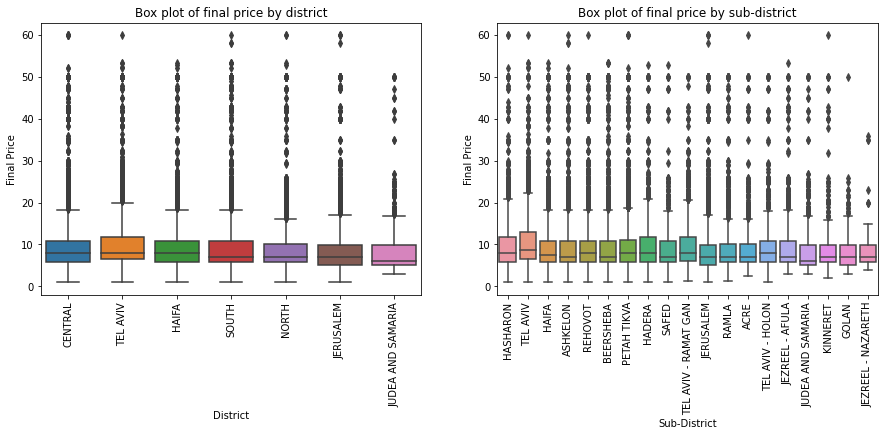

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.boxplot(x='DistrictName', y='FinalPrice', data=data_agg, ax=ax[0])
ax[0].set_xlabel('District')
ax[0].set_ylabel('Final Price')
ax[0].set_title('Box plot of final price by district')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.boxplot(x='SubDistrictName', y='FinalPrice', data=data_agg, ax=ax[1])
ax[1].set_xlabel('Sub-District')
ax[1].set_ylabel('Final Price')
ax[1].set_title('Box plot of final price by sub-district')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.show()

The boxplots provide us insight into the heterogeneity in the final price across different regions, which can be useful for business planning and decision making. We see that the district and sub-district variables are skewed, but also might be important factors that affect the final price.

In the next boxplot we see more significant difference between the store types on the final price.

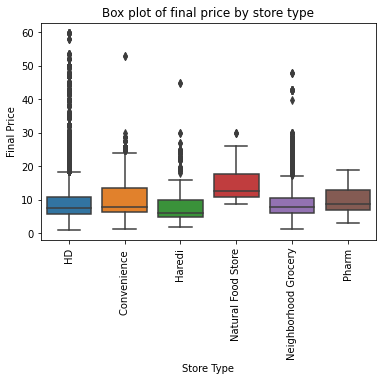

In [7]:
fig, ax = plt.subplots()
sns.boxplot(x='StoreType', y='FinalPrice', data=data_agg, ax=ax)
ax.set_xlabel('Store Type')
ax.set_ylabel('Final Price')
ax.set_title('Box plot of final price by store type')
plt.xticks(rotation=90)
plt.show()

#### Mapping price distribution

Visualizing the distribution of prices between statistical areas on a map help us to identify spatial patterns, dependencies or outliers that we should take into account when estimating the impact of price determinants.

We will visualize here the spatial distribution between statistical areas in the 4 biggest cities in Israel.

<ipython-input-8-42aa3432e0db>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_agg_sa = data_agg.groupby('StatisticalArea').mean().reset_index()[['StatisticalArea','FinalPrice']]
C:\Users\Israel\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


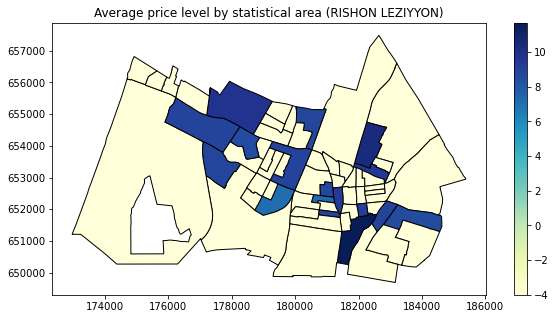

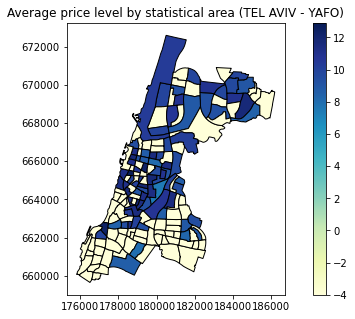

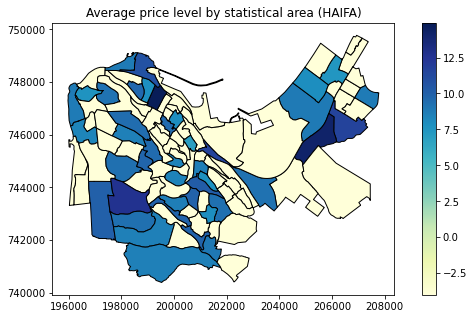

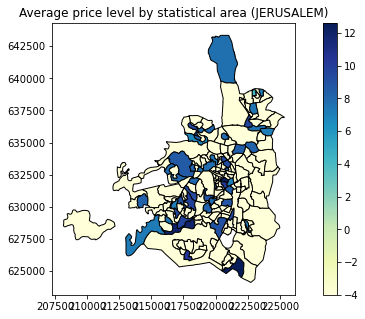

In [8]:
# average the price level by statistical area
data_agg_sa = data_agg.groupby('StatisticalArea').mean().reset_index()[['StatisticalArea','FinalPrice']]
data_agg_drop_price = data_agg.drop(columns=['FinalPrice']).groupby('StatisticalArea').first().reset_index()
data_merged = data_agg_sa.merge(data_agg_drop_price, on='StatisticalArea', how='left')

# load the district/city boundary shapefiles
shapefile = gpd.read_file("C:/Users/subjects/thesis/data/Lamas_Census_Tracts_2011.shp")

# merge the shapefile with the average price data
shapefile = shapefile.merge(data_merged, left_on='STA', right_on='StatisticalArea', how='left')

# Create a list of cities to filter by
cities = ['RISHON LEZIYYON', 'TEL AVIV - YAFO', 'HAIFA', 'JERUSALEM']

# Create a subplot for each city
for i, city in enumerate(cities):    
    shapefile_city = shapefile[shapefile['SHEM_YIS_1'].isin([city])]
    shapefile_city['FinalPrice'] = shapefile_city['FinalPrice'].fillna(value=-4)
    
    shapefile_city.plot(column='FinalPrice', cmap='YlGnBu', legend=True, figsize=(10,5), edgecolor='black')
    plt.title(f'Average price level by statistical area ({city})')
    plt.show()

We see that the prices are not evenly distributed and it may suggest that there are also spatial determinants of prices.

#### Chi-squared test

We wiil perform a chi-squared test of independence on the categorical variables in our data to identify which variables are most likely to be related to the prices. The test compares the observed frequency of values between two variables to the expected frequency of values. This can help us to decide which variables may have a significant impact on the dependent variable and should be included in the analysis.

In [9]:
cat_cols = ['ProductDescription', 'Manufacturer_fact', 'ChainName', 'StoreType','SubChainName', 'StoreName', 'DistrictName', 'SubDistrictName', 'LocationType' ,'CityName', 'StatisticalArea']
p_value_threshold = 0.05

# list to store the selected variables
selected_vars = []

for col in cat_cols:
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(data_agg['FinalPrice'], data_agg[col]))
    print(f'{col} - Chi2:{chi2}, P-value:{p}')
    
    if p < p_value_threshold:
        selected_vars.append(col)

# show the selected variables
print('Selected variables:', selected_vars)

ProductDescription - Chi2:3325073.5571774533, P-value:0.0
Manufacturer_fact - Chi2:1059306.742855958, P-value:0.0
ChainName - Chi2:133959.18498596968, P-value:0.0
StoreType - Chi2:41980.67271142018, P-value:0.0
SubChainName - Chi2:222911.99206424234, P-value:0.0
StoreName - Chi2:500971.86694332195, P-value:0.0
DistrictName - Chi2:13618.5359890779, P-value:0.0
SubDistrictName - Chi2:23969.6137005219, P-value:0.0
LocationType - Chi2:12893.394704128164, P-value:0.0
CityName - Chi2:131757.449076483, P-value:0.0
StatisticalArea - Chi2:445547.884153876, P-value:0.0
Selected variables: ['ProductDescription', 'Manufacturer_fact', 'ChainName', 'StoreType', 'SubChainName', 'StoreName', 'DistrictName', 'SubDistrictName', 'LocationType', 'CityName', 'StatisticalArea']


When we perform a chi-squared test, a high statistic value suggests that there is a relationship between two variables. This means that their distribution is not as expected if they were truly independent. In other words, one variable is influenced by the other. Therefore it is more likely that the independent categorial variable will be a useful predictor in the regression model.

## Regression analysis

Here we will test different regression techniques, check for their validity and evalute the results with different evaluation metrics.

### Ordinary least squares (OLS)

The model assumes that the relationship between the independent and dependent variables is linear, that the errors are normally distributed and have equal variances (homoscedasticity), and that there is no multicollinearity among the independent variables.

#### Model specification

We will choose the dependent and independent variables and define the form of the regression model.

$$ \log FinalPrice = \beta_0 + \beta_1Manufacturer + \beta_2City + \beta_3StoreType + \beta_4LocationType + \beta_5SocioEconomicIndex + \beta_6PeripheralityIndex + \epsilon $$

In [10]:
# Apply one-hot encoding to the categorical columns
#categorial_X = data_agg[['StoreID','ProductDescription','Manufacturer','ChainName','SubChainName','DistrictName', 'SubDistrictName',
#       'CityName', 'StoreType', 'StatisticalArea']]
categorial_X = data_agg[['Manufacturer_fact','StoreType','CityName','LocationType']]
categorial_X = pd.get_dummies(categorial_X, drop_first=True)
# Concatenate the one-hot encoded categorical data with the numerical data
X = pd.concat([categorial_X, data_agg[['SocioEconomicCity','PeripheralityIndex']]], axis=1)
y = data_agg["FinalPrice"]

##### Removing influential observations with Cook's distance

We will remove outliers that can have a significant impact on the regression results with Cook's distance. It is calculated as the difference in the residual sum of squares between the original regression model and a model fit with that single data point removed. Larger values indicate a influence and potential for being an outlier or influential observation.

The threshold we choose is based on the assumption that the distribution of Cook's distance follows an asymptotic chi-squared distribution, and that values greater than this threshold fall in the tail of this distribution.

In [11]:
# To compute Cook's distance we will first run OLS
ols_model = OLS(y, X)
ols_results = ols_model.fit()

influence = OLSInfluence(ols_results)
cooks_distance, p_values = influence.cooks_distance
# Remove influential observations
high_influence_obs = np.where(cooks_distance > 4/(len(X)-2))
clean_data = data_agg.drop(data_agg.index[high_influence_obs[0]])

print('Number of removed observations:', len(high_influence_obs[0]))

Number of removed observations: 3072


C:\Users\Israel\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


##### Data transformation

We will also use data transformation to reduce skewness and improve the normality of the data. By taking the log of the price, the distribution of the transformed variable can become more symmetrical and closer to a normal distribution.

In [12]:
clean_data["FinalPrice"] = np.log(clean_data["FinalPrice"])

By removing outliers and data transformation, we are increasing the robustness of the regression models. Now we can refit the model with the cleaned data

#### Estimation

In [13]:
categorial_X = clean_data[['Manufacturer_fact','StoreType','CityName','LocationType']]
categorial_X = pd.get_dummies(categorial_X, drop_first=True)
X_clean = pd.concat([categorial_X, clean_data[['SocioEconomicCity','PeripheralityIndex']]], axis=1)
y_clean = clean_data["FinalPrice"]

model_ols = OLS(y_clean, X_clean)
results_ols = model_ols.fit()

#### Regression diagnostic

After estimating the model, we will try to identify potential issues that may affect the reliability and interpretability of the regression results.

##### Homoscedasticity

We will check for homoscedasticity to ensure that the residuals are evenly spread across the entire range of independent variables. Checking for homoscedasticity is important because if the variance of the residuals is not constant, then the results of the regression analysis could be biased or misleading. Checking for homoscedasticity involves visually inspecting the residual plot.

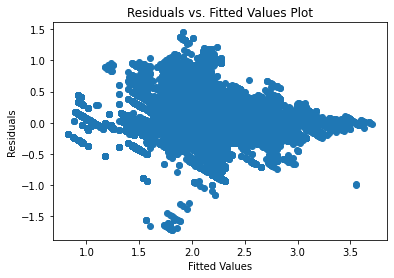

In [14]:
# Plotting the residuals vs. fitted values plot
plt.scatter(results_ols.fittedvalues, results_ols.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

From the plot we get an indication that the mean seems constant and the variance of the residuals is not constant. We will also use statistical test to confirm it. 

###### Breusch-Pagan test
The Breusch-Pagan test is a chi-squared test that tests the null hypothesis that the error variance is homoscedastic. If the p-value from the test is less than the significance level, this indicates that the residuals are heteroscedastic. 

In [15]:
_, pval, _, _ = het_breuschpagan(results_ols.resid, results_ols.model.exog)
if pval < 0.05:
    print("The residuals are heteroscedastic.")
else:
    print("The residuals are homoscedastic.")

The residuals are heteroscedastic.


Since we see that homoscedasticity is not present, we will consider to apply techniques like WLS to account for the non-constant variance.

##### Multicollinearity

Multicollinearity occurs when the independent variables are highly correlated with each other. This can lead to problems in estimating the parameters of the model and interpreting their significance. 

###### Variance inflation factor (VIF)
To check the presence of multicollinearity we will use VIF. It is calculated as the ratio of variance in the predicted values of the dependent variable when a given independent variable is included in the model, divided by the variance in the predicted values when that variable is excluded from the model. If the VIF of an independent variable is high, it indicates that there is a high degree of multicollinearity between that variable and the other independent variables in the model. Typically, a VIF value greater than 10 is considered as an indication of high multicollinearity and suggests that the independent variable may need to be removed or transformed to reduce the correlation with the other variables.

In [16]:
exog = results_ols.model.exog
vif = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]

if any(v > 10 for v in vif):
    print("Multicollinearity may be present.")
else:
    print("Multicollinearity is not present.")

vif_df = pd.DataFrame({'Predictor': X_clean.columns, 'VIF': vif})
vif_df.sort_values(by='VIF', ascending=False)

Multicollinearity may be present.


,Predictor,VIF
252,SocioEconomicCity,100098.972639
253,PeripheralityIndex,20033.085849
158,CityName_JERUSALEM,15131.111205
236,CityName_TEL AVIV - YAFO,7143.271877
111,CityName_BENE BERAQ,2561.175409
...,...,...
79,Manufacturer_fact_84,1.010187
5,Manufacturer_fact_15,1.009666
34,Manufacturer_fact_42,1.008857
81,Manufacturer_fact_86,1.004265


###### Handling multicollinearity

To address the multicollinearity, we will remove the predictors with high VIF values by continuously updating the VIFs for each predictor as predictors are removed. 

In [17]:
def remove_vif_predictors(X, vif_threshold=10):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_df = pd.DataFrame({'Predictor': X.columns, 'VIF': vif})
    while vif_df['VIF'].max() > vif_threshold:
        predictor_to_remove = vif_df.loc[vif_df['VIF'].idxmax()]['Predictor']
        X = X.drop(predictor_to_remove, axis=1)
        vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_df = pd.DataFrame({'Predictor': X.columns, 'VIF': vif})
    return X, vif_df

X_clean, vif_df = remove_vif_predictors(X_clean)
X_clean = pd.concat([X_clean, clean_data[['SocioEconomicCity','PeripheralityIndex']]], axis=1)
model_ols = OLS(y_clean, X_clean)
results_ols = model_ols.fit()

print("Multicollinearity is not present.")
vif_df.sort_values(by='VIF', ascending=False)

Multicollinearity is not present.


,Predictor,VIF
0,LocationType,4.331652
90,StoreType_Neighborhood Grocery,1.966280
48,Manufacturer_fact_56,1.905131
234,CityName_TEL AVIV - YAFO,1.833920
88,StoreType_Haredi,1.728777
...,...,...
9,Manufacturer_fact_19,1.000806
111,CityName_BEROR HAYIL,1.000464
174,CityName_MA'OZ HAYYIM,1.000335
160,CityName_KEFAR BIN NUN,1.000263


##### Endogeneity

Endogeneity occurs when the error term in a regression model is correlated with one or more of the independent variables. This can lead to biased and inconsistent estimates of the parameters, and can make it difficult to determine the causal effect of the determinants of prices. In our case, endogeneity can arise from omitted variable bias or measurement error.

###### Two-stage least squares (2SLS) method

We will use the 2SLS method to address endogeneity in the OLS model. We assume the original model (the first stage) suffers from endogeneity bias. The residuals from the first stage regression are used as an additional exogenous variable in the second stage regression, which is expected to produce more efficient estimates of the parameters. The results of the second stage regression will be used to assess the validity of the estimated parameters.

In [18]:
# Fit the first stage regression
X_clean_1 = X_clean.copy()
X_clean_1['const'] = 1
stage1 = OLS(y_clean, X_clean_1).fit()

# Get the residuals from the first stage regression
residuals = stage1.resid

# Add the residuals as an exogenous variable to the original predictors
X_clean_2 = pd.concat([X_clean_1, residuals], axis=1)

# Fit the second stage regression
stage2 = OLS(y_clean, X_clean_2).fit()

t_value, p_value = stats.ttest_ind(stage1.params, stage2.params)

if p_value < 0.05:
    print("The coefficients are significantly different, indicating endogeneity.")
else:
    print("The coefficients are not significantly different, indicating no endogeneity.")

The coefficients are not significantly different, indicating no endogeneity.


#### Regression validation

Now, we will verify the performance of the regression model by evaluating the results with statistical metrics. First, let's examine the magnitude, significance and direction of the relationship between your independent variables and dependent variable.

In [19]:
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             FinalPrice   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     285.0
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:01:19   Log-Likelihood:                -18645.
No. Observations:               70483   AIC:                         3.779e+04
Df Residuals:                   70231   BIC:                         4.010e+04
Df Model:                         251                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Location

Based on our regression analysis, we found that peripherality and socio-economic level are significant determinants of prices. The model explained 50.5% of the variation in prices, which is not a very high R-squared value but still acceptable. From the OLS regression resultes, we will also consider several metrics:

##### F-test

We use F-test to check the overall fit our a model

In [20]:
f_statistic = results_ols.fvalue
prob_f = results_ols.f_pvalue
print("F-statistic: ", f_statistic)
print("Prob(F-statistic): ", prob_f)

F-statistic:  285.0248658752491
Prob(F-statistic):  0.0


##### Goodness of fit: R-squared and adjusted R-squared

The R-squared represents the amount of variation in the dependent variable that is explained by the independent variables in the model. The adjusted R-squared provides a better indication of the goodness of fit.

In [21]:
r_squared = results_ols.rsquared
print("R-squared: ", r_squared)
adj_r_squared = results_ols.rsquared_adj
print("Adjusted R-squared: ", adj_r_squared)

R-squared:  0.5046209375063571
Adjusted R-squared:  0.5028504921946584


When we remove the 'Peripherality Index' variable from the model specification we get higher R-squared of 0.9. However, since our goal is to get a general sense of the relationship between the variables and to identify the most important predictors. Also, there may be other important factors that we did not consider in our analysis. Additionally, R-squared alone is not enough to determine the quality of a regression model, it's important to consider other evaluation metrics such as RMSE. 

##### Root mean squared error (RMSE)

The RMSE helps to understand the magnitude of the error in the model's predictions and will be useful for model selection.

In [22]:
predictions = results_ols.predict(X_clean)
mse = np.mean((predictions - y_clean)**2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

Root Mean Squared Error:  0.31524638930987975


The RMSE that we get here can indicate that the model is able to predict the price relatively close to the true values.

### Weighted least squares (WLS)

Heteroscedasticity can cause problems in OLS estimation, such as biased coefficient estimates and incorrect standard errors. WLS is a modified version of OLS that takes into account the heteroscedasticity of the errors by using weights in the regression that are proportional to the inverse of the variance of the errors.

By weighting each observation by its inverse variance, WLS downweights observations with large error variances and upweights observations with small error variances. This helps to mitigate the effects of heteroscedasticity and can lead to more efficient and unbiased estimates of the regression coefficients.

#### Model specification

In terms of model specification, WLS requires specifying the appropriate weight function that reflects the relationship between the variance of the error term and the independent variables.

$$ \log FinalPrice = \beta_0 + \beta_1 Manufacturer + \beta_2 City + \beta_3 StoreType + \beta_4 LocationType + \beta_5 SocioEconomicIndex + \beta_6 PeripheralityIndex + \epsilon $$

where $\epsilon$ is a vector of errors with non-constant variance, and the weight for each observation is given by the inverse of the variance of the error:

$$ w_i = \frac{1}{\sigma_i^2} $$

where $\sigma_i^2$ is the variance of the error for observation i.

##### Removing influential observations with Cook's distance and data transformation

We will repeate the process as before but now we use WLS method for detecting influential observations.

In [23]:
# Define the weight function
def weight_function(errors):
    return 1 / errors**2

# Compute the weights using the residual errors from the OLS model
ols_model = OLS(y, X)
ols_results = ols_model.fit()
w = weight_function(ols_results.resid)

# Fit the WLS model
wls_model = WLS(y, X, weights=w)
wls_results = wls_model.fit()

influence = OLSInfluence(wls_results)
cooks_distance, p_values = influence.cooks_distance
# Remove influential observations
high_influence_obs = np.where(cooks_distance > 4/(len(X)-2))
clean_data = data_agg.drop(data_agg.index[high_influence_obs[0]])

print('Number of removed observations:', len(high_influence_obs[0]))

# Data transformation
clean_data["FinalPrice"] = np.log(clean_data["FinalPrice"])

Number of removed observations: 3463


#### Estimation

In [24]:
categorical_X = clean_data[['Manufacturer_fact','StoreType','CityName','LocationType']]
categorical_X = pd.get_dummies(categorical_X, drop_first=True)
X_clean = pd.concat([categorical_X, clean_data[['SocioEconomicCity','PeripheralityIndex']]], axis=1)
y_clean = clean_data['FinalPrice']

# Fit the OLS model to get the residuals to define the weight function and calculate their variance
model_ols = OLS(y_clean, X_clean)
results_ols = model_ols.fit()
residuals = results_ols.resid
residual_var = np.var(residuals)
weights = 1/residual_var

model_wls = WLS(y_clean, X_clean, weights=weights)
results_wls = model_wls.fit()

#### Regression diagnostic

##### Homoscedasticity

Homoscedasticity is still an important assumption in WLS, just as it is in OLS. In WLS, the weights are designed to give more weight to observations with smaller variance and less weight to observations with larger variance. If the variance of the errors is not constant, the weights may not be appropriately estimated, which could lead to biased and inefficient estimates.

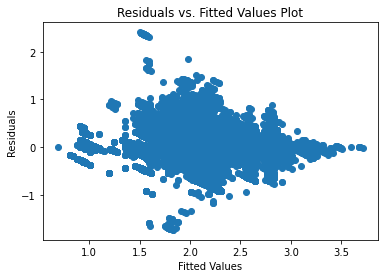

In [25]:
# Plotting the residuals vs. fitted values plot
plt.scatter(results_wls.fittedvalues, results_wls.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

From the plot we get an indication also here that the mean is constant and the variance of the residuals is not constant. We will also use statistical test to confirm it. 

###### Breusch-Pagan test

In [26]:
_, pval, _, _ = het_breuschpagan(results_wls.resid, results_wls.model.exog)
if pval < 0.05:
    print("The residuals are heteroscedastic.")
else:
    print("The residuals are homoscedastic.")

The residuals are heteroscedastic.


Since we see that homoscedasticity is not present, we will consider to apply other techniques like GLS which allows for more flexibility in the modeling of the variance structure and can provide more efficient estimates than WLS when the covariance structure is correctly specified.

##### Multicollinearity

In WLS, multicollinearity can also have an impact on the weights assigned to each observation. If the independent variables are highly correlated, then the weights assigned to the observations can become unstable, leading to unreliable results.

###### Variance inflation factor (VIF)

In [27]:
exog = results_wls.model.exog
vif = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]

if any(v > 10 for v in vif):
    print("Multicollinearity may be present.")
else:
    print("Multicollinearity is not present.")

vif_df = pd.DataFrame({'Predictor': X_clean.columns, 'VIF': vif})
vif_df.sort_values(by='VIF', ascending=False)

Multicollinearity may be present.


,Predictor,VIF
247,SocioEconomicCity,99219.496198
248,PeripheralityIndex,19941.722520
153,CityName_JERUSALEM,15047.383025
231,CityName_TEL AVIV - YAFO,6971.684280
107,CityName_BENE BERAQ,2601.383259
...,...,...
5,Manufacturer_fact_15,1.008803
31,Manufacturer_fact_42,1.008105
77,Manufacturer_fact_86,1.004003
32,Manufacturer_fact_43,1.001998


###### Handling multicollinearity

In [28]:
def remove_vif_predictors(X, vif_threshold=10):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_df = pd.DataFrame({'Predictor': X.columns, 'VIF': vif})
    while vif_df['VIF'].max() > vif_threshold:
        predictor_to_remove = vif_df.loc[vif_df['VIF'].idxmax()]['Predictor']
        X = X.drop(predictor_to_remove, axis=1)
        vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_df = pd.DataFrame({'Predictor': X.columns, 'VIF': vif})
    return X, vif_df

X_clean, vif_df = remove_vif_predictors(X_clean)
X_clean = pd.concat([X_clean, clean_data[['SocioEconomicCity','PeripheralityIndex']]], axis=1)

model_ols = OLS(y_clean, X_clean)
results_ols = model_ols.fit()
residuals = results_ols.resid
residual_var = np.var(residuals)
weights = 1/residual_var

model_wls = WLS(y_clean, X_clean, weights=weights)
results_wls = model_wls.fit()

print("Multicollinearity is not present.")
vif_df.sort_values(by='VIF', ascending=False)

Multicollinearity is not present.


,Predictor,VIF
0,LocationType,4.360250
86,StoreType_Neighborhood Grocery,1.977325
45,Manufacturer_fact_56,1.916629
229,CityName_TEL AVIV - YAFO,1.809093
84,StoreType_Haredi,1.768555
...,...,...
66,Manufacturer_fact_76,1.000370
235,CityName_YASHRESH,1.000192
107,CityName_BEROR HAYIL,1.000178
169,CityName_MA'OZ HAYYIM,1.000172


##### Endogeneity

Endogeneity is also important in WLS for the same reasons it is important in OLS. In WLS, endogeneity can be particularly problematic if the weighting function is based on a variable that is correlated with the error term. This can result in biased and inconsistent estimates of the regression coefficients, even if the weighting function is chosen correctly.

###### Two-stage least squares (2SLS) method

In [29]:
# Fit the first stage regression
X_clean_1 = X_clean.copy()
X_clean_1['const'] = 1
stage1 = WLS(y_clean, X_clean_1, weights=weights).fit()

# Get the residuals from the first stage regression
residuals = stage1.resid

# Add the residuals as an exogenous variable to the original predictors
X_clean_2 = pd.concat([X_clean_1, residuals], axis=1)

# Fit the second stage regression
stage2 = WLS(y_clean, X_clean_2, weights=weights).fit()

t_value, p_value = stats.ttest_ind(stage1.params, stage2.params)

if p_value < 0.05:
    print("The coefficients are significantly different, indicating endogeneity.")
else:
    print("The coefficients are not significantly different, indicating no endogeneity.")

The coefficients are not significantly different, indicating no endogeneity.


#### Regression validation

In [30]:
print(results_wls.summary())

                            WLS Regression Results                            
Dep. Variable:             FinalPrice   R-squared:                       0.443
Model:                            WLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     225.5
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:59:06   Log-Likelihood:                -23153.
No. Observations:               70092   AIC:                         4.680e+04
Df Residuals:                   69845   BIC:                         4.906e+04
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Location

##### F-test

In [31]:
f_statistic = results_wls.fvalue
prob_f = results_wls.f_pvalue
print("F-statistic: ", f_statistic)
print("Prob(F-statistic): ", prob_f)

F-statistic:  225.495918599436
Prob(F-statistic):  0.0


##### Goodness of fit: R-squared and adjusted R-squared

In [32]:
r_squared = results_wls.rsquared
print("R-squared: ", r_squared)
adj_r_squared = results_wls.rsquared_adj
print("Adjusted R-squared: ", adj_r_squared)

R-squared:  0.44265341300012817
Adjusted R-squared:  0.44069039116031183


##### Root mean squared error (RMSE)

In [33]:
predictions = results_wls.predict(X_clean)
mse = np.mean((predictions - y_clean)**2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

Root Mean Squared Error:  0.33668389399955606


### Generalized least squares (GLS)

GLS is another method that can be used to address heteroscedasticity in regression analysis. Unlike WLS, which assumes that the error variances are known, GLS estimates both the regression coefficients and the variance-covariance matrix of the errors simultaneously. GLS is useful when the variance-covariance matrix of the errors is not known but can be estimated. By incorporating the estimated variance-covariance matrix into the estimation procedure, GLS can correct for heteroscedasticity and provide unbiased and efficient estimates of the regression coefficients.

#### Model specification

In terms of model specification, GLS requires specifying the variance-covariance matrix of the errors. The GLS model can be written as:

$$ \log FinalPrice = \beta_0 + \beta_1 Manufacturer + \beta_2 City + \beta_3 StoreType + \beta_4 LocationType + \beta_5 SocioEconomicIndex + \beta_6 PeripheralityIndex + \epsilon $$

where $\epsilon \sim N(0, \Sigma)$, where $\Sigma$ is the variance-covariance matrix of the errors.

##### Removing influential observations with Cook's distance and data transformation

In [34]:
# Define the weight function
def weight_function(errors):
    return 1 / np.abs(errors)

# Compute the weights using the residual errors from the OLS model
ols_model = OLS(y, X)
ols_results = ols_model.fit()
w = weight_function(ols_results.resid)

# Fit the GLS model
gls_model = GLS(y, X, weights=w)
gls_results = gls_model.fit()

influence = OLSInfluence(gls_results)
cooks_distance, p_values = influence.cooks_distance
# Remove influential observations
high_influence_obs = np.where(cooks_distance > 4/(len(X)-2))
clean_data = data_agg.drop(data_agg.index[high_influence_obs[0]])

print('Number of removed observations:', len(high_influence_obs[0]))

# Data transformation
clean_data["FinalPrice"] = np.log(clean_data["FinalPrice"])

C:\Users\Israel\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Number of removed observations: 3072


#### Estimation

We estimate the GLS model by using weights obtained from the residual errors of an OLS model.

In [35]:
categorical_X = clean_data[['Manufacturer_fact','StoreType','CityName','LocationType']]
categorical_X = pd.get_dummies(categorical_X, drop_first=True)
X_clean = pd.concat([categorical_X, clean_data[['SocioEconomicCity','PeripheralityIndex']]], axis=1)
y_clean = clean_data['FinalPrice']

# Fit the OLS model and the the GLS model to estimate the variance-covariance matrix
model_ols = OLS(y_clean, X_clean)
results_ols = model_ols.fit()
w = weight_function(results_ols.resid)
model_gls = GLS(y_clean, X_clean, weights=w)
results_gls = model_gls.fit()

#### Regression diagnostic

##### Homoscedasticity

In GLS, the weights are computed as the inverse of the estimated residual variances from a preliminary OLS regression, assuming that the errors are normally distributed with constant variance. If the assumption of homoscedasticity is not satisfied, the estimated variance-covariance matrix will be incorrect, leading to biased and inefficient estimates of the regression coefficients.

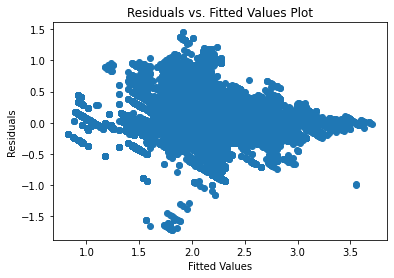

In [36]:
# Plotting the residuals vs. fitted values plot
plt.scatter(results_gls.fittedvalues, results_gls.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

From the plot we get an indication also here that the mean seems constant and the variance of the residuals is not constant. We will also use statistical test to confirm it. 

###### Breusch-Pagan test

In [37]:
_, pval, _, _ = het_breuschpagan(results_gls.resid, results_gls.model.exog)
if pval < 0.05:
    print("The residuals are heteroscedastic.")
else:
    print("The residuals are homoscedastic.")

The residuals are heteroscedastic.


Since we see that homoscedasticity is not present, we can consider to apply other techniques like heteroskedasticity-consistent standard errors (HCSE) which allows us to estimate the standard errors of the model coefficients that are robust to violations of the assumption of homoskedasticity.

##### Multicollinearity

In GLS, as in WLS, multicollinearity can have an impact on the variance-covariance matrix estimation, and thus on the reliability of the GLS results. When the independent variables are highly correlated, the inverse of the variance-covariance matrix becomes unstable, leading to unreliable results.

###### Variance inflation factor (VIF)

In [38]:
exog = results_gls.model.exog
vif = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]

if any(v > 10 for v in vif):
    print("Multicollinearity may be present.")
else:
    print("Multicollinearity is not present.")

vif_df = pd.DataFrame({'Predictor': X_clean.columns, 'VIF': vif})
vif_df.sort_values(by='VIF', ascending=False)

Multicollinearity may be present.


,Predictor,VIF
252,SocioEconomicCity,100098.972639
253,PeripheralityIndex,20033.085849
158,CityName_JERUSALEM,15131.111205
236,CityName_TEL AVIV - YAFO,7143.271877
111,CityName_BENE BERAQ,2561.175409
...,...,...
79,Manufacturer_fact_84,1.010187
5,Manufacturer_fact_15,1.009666
34,Manufacturer_fact_42,1.008857
81,Manufacturer_fact_86,1.004265


###### Handling multicollinearity

In [39]:
def remove_vif_predictors(X, vif_threshold=10):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_df = pd.DataFrame({'Predictor': X.columns, 'VIF': vif})
    while vif_df['VIF'].max() > vif_threshold:
        predictor_to_remove = vif_df.loc[vif_df['VIF'].idxmax()]['Predictor']
        X = X.drop(predictor_to_remove, axis=1)
        vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_df = pd.DataFrame({'Predictor': X.columns, 'VIF': vif})
    return X, vif_df

X_clean, vif_df = remove_vif_predictors(X_clean)
X_clean = pd.concat([X_clean, clean_data[['SocioEconomicCity','PeripheralityIndex']]], axis=1)

model_ols = OLS(y_clean, X_clean)
results_ols = model_ols.fit()
w = weight_function(results_ols.resid)
model_gls = GLS(y_clean, X_clean, weights=w)
results_gls = model_gls.fit()

print("Multicollinearity is not present.")
vif_df.sort_values(by='VIF', ascending=False)

Multicollinearity is not present.


,Predictor,VIF
0,LocationType,4.331652
90,StoreType_Neighborhood Grocery,1.966280
48,Manufacturer_fact_56,1.905131
234,CityName_TEL AVIV - YAFO,1.833920
88,StoreType_Haredi,1.728777
...,...,...
9,Manufacturer_fact_19,1.000806
111,CityName_BEROR HAYIL,1.000464
174,CityName_MA'OZ HAYYIM,1.000335
160,CityName_KEFAR BIN NUN,1.000263


##### Endogeneity

If the errors are correlated with one or more of the independent variables, then the GLS estimator may no longer be efficient or unbiased, and the estimated standard errors may be incorrect. In GLS, the weighting matrix is typically estimated using the residuals from an initial OLS regression. If there is endogeneity in the model, the OLS residuals will be correlated with the errors from the GLS regression, leading to biased and inconsistent estimates of the regression coefficients. 

###### Two-stage least squares (2SLS) method

In [40]:
# Fit the first stage regression
X_clean_1 = X_clean.copy()
X_clean_1['const'] = 1
stage1 = GLS(y_clean, X_clean_1, weights=w).fit()

# Get the residuals from the first stage regression
residuals = stage1.resid

# Add the residuals as an exogenous variable to the original predictors
X_clean_2 = pd.concat([X_clean_1, residuals], axis=1)

# Fit the second stage regression
stage2 = GLS(y_clean, X_clean_2, weights=w).fit()

t_value, p_value = stats.ttest_ind(stage1.params, stage2.params)

if p_value < 0.05:
    print("The coefficients are significantly different, indicating endogeneity.")
else:
    print("The coefficients are not significantly different, indicating no endogeneity.")

The coefficients are not significantly different, indicating no endogeneity.


#### Regression validation

In [41]:
print(results_gls.summary())

                            GLS Regression Results                            
Dep. Variable:             FinalPrice   R-squared:                       1.000
Model:                            GLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.241e+11
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:28:03   Log-Likelihood:                -18645.
No. Observations:               70483   AIC:                         3.779e+04
Df Residuals:                   70231   BIC:                         4.010e+04
Df Model:                         251                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Location

##### F-test

In [42]:
f_statistic = results_gls.fvalue
prob_f = results_gls.f_pvalue
print("F-statistic: ", f_statistic)
print("Prob(F-statistic): ", prob_f)

F-statistic:  824119593206.4927
Prob(F-statistic):  0.0


##### Goodness of fit: R-squared and adjusted R-squared

In [43]:
r_squared = results_gls.rsquared
print("R-squared: ", r_squared)
adj_r_squared = results_gls.rsquared_adj
print("Adjusted R-squared: ", adj_r_squared)

R-squared:  0.9999999996604804
Adjusted R-squared:  0.999999999659267


##### Root mean squared error (RMSE)

In [44]:
predictions = results_gls.predict(X_clean)
mse = np.mean((predictions - y_clean)**2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

Root Mean Squared Error:  0.31524638930987975


### Model comparison

Comparing the results of the three models, OLS, WLS, and GLS, can provide insight into the effect of heteroscedasticity on the regression analysis. OLS assumes homoscedasticity, while WLS and GLS account for heteroscedasticity in different ways. If the results of the WLS and GLS models are similar to the OLS model, this may suggest that heteroscedasticity is not a major issue in the data. However, if the results of the WLS and GLS models differ substantially from the OLS model, this may indicate that heteroscedasticity is present in the data and that accounting for it through the use of WLS or GLS is necessary for obtaining reliable estimates.

##### AIC (Akaike information criterion) and BIC (Bayesian information criterion)

The AIC and BIC are used to compare the fit of different models to the data, where lower values of AIC and BIC indicate a better fit. These criteria take into account the number of parameters in the model, so models with more parameters are penalized and may have higher AIC and BIC values. It is generally recommended to use both AIC and BIC to compare models, as they can give different results and provide complementary information.

In [45]:
# Compare the performance of the models
print('Model performance:')
print('OLS AIC:', results_ols.aic)
print('OLS BIC:', results_ols.bic)

print('WLS AIC:', results_wls.aic)
print('WLS BIC:', results_wls.bic)

print('GLS AIC:', results_gls.aic)
print('GLS BIC:', results_gls.bic)

# Extract R-squared and RMSE from each model
r2_ols = results_ols.rsquared
r2_wls = results_wls.rsquared
r2_gls = results_gls.rsquared
print('\nR-squared:')
print(f"OLS: {r2_ols:.4f}")
print(f"WLS: {r2_wls:.4f}")
print(f"GLS: {r2_gls:.4f}")

rmse_ols = np.sqrt(results_ols.mse_resid)
rmse_wls = np.sqrt(results_wls.mse_resid)
rmse_gls = np.sqrt(results_gls.mse_resid)
print('\nRoot Mean Squared Error:')
print(f"OLS: {rmse_ols:.4f}")
print(f"WLS: {rmse_wls:.4f}")
print(f"GLS: {rmse_gls:.4f}")

OLS AIC: 37794.83207292763
OLS BIC: 40103.940032820305
WLS AIC: 46800.664517645346
WLS BIC: 49062.58281177094
GLS AIC: 37794.83207292762
GLS BIC: 40103.94003282029
R-squared:
OLS: 0.5046
WLS: 0.4427
GLS: 1.0000

Root Mean Squared Error:
OLS: 0.3158
WLS: 1.0018
GLS: 0.3158


Based on the results, we observed that the GLS model has an R-squared value that is very close to 1, indicating that almost all of the variance in the dependent variable is explained by the independent variables in the model. However, this may not be a good indicator of how well the model will perform as it may be overfitting the data. On the other hand, the OLS model had a significantly lower R-squared value of 0.5. Additionally, the WLS model had even lower R-squared value compared to both OLS and GLS models.

When we compared the RMSE values of these three models, we found that the OLS and GLS models have similar values, whereas the WLS model have a higher value. In addition, the AIC and BIC for OLS and GLS are similar, while for WLS, they are higher, which suggests that OLS and GLS models are better at balancing model fit and complexity.

Therefore, based on the analysis so far, we would prefer to use the OLS model. while the OLS model may not be capturing all of the variation in the data, it has a more reasonable R-squared value compared to the GLS model, and it also performs equally well in terms of the RMSE value. Additionally, the OLS model is easier to interpret and explain.

In the future we will consider using other statistical techniques, such as like 2SLS and LAD.